In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import time
import torchvision.models as models

In [132]:
device = torch.device("mps" if torch.mps.is_available() else "cpu")
device

device(type='mps')

### Load Dataset

In [135]:
image_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness = 0.2, contrast = 0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

In [137]:
dataset_path = "./dataset"

dataset = datasets.ImageFolder(root = dataset_path, transform = image_transforms)
len(dataset)

2300

In [168]:
class_names = dataset.classes
class_names

['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']

In [141]:
num_classes = len(dataset.classes)
num_classes

6

In [143]:
train_size = int(len(dataset)*0.75)
val_size = len(dataset) - train_size
train_size, val_size

(1725, 575)

In [145]:
from torch.utils.data import random_split

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [147]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [149]:
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [150]:
labels[0]

tensor(2)

In [153]:
images[0].shape

torch.Size([3, 224, 224])

In [155]:
images[0].permute(1,2,0).shape

torch.Size([224, 224, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


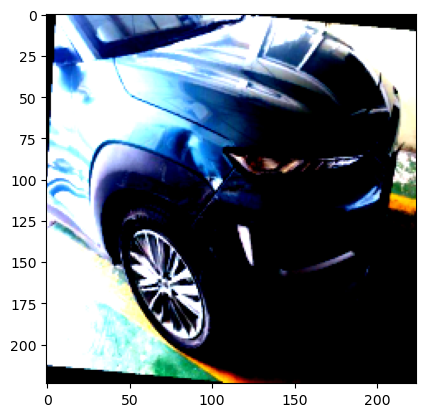

In [65]:
plt.imshow(images[0].permute(1,2,0))
plt.show()

### Model 1 : CNN

In [72]:
class CarClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),  # (16, 224, 224)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (16, 112, 112)
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),  
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (32, 56, 56)
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),  
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (64, 28, 28)
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.network(x)
        return x

In [86]:
model = CarClassifierCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [92]:
def train_model(model, criterion, optimizer, epochs=5):
    start = time.time()
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_num, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            if (batch_num+1) % 10 == 0:
                print(f"Batch: {batch_num+1}, Epoch: {epoch+1}, Loss: {loss.item():0.2f}")
            
            running_loss += loss.item() * images.size(0)
            
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}], Avg Loss: {epoch_loss:.4f}")

        # Validation
        model.eval()
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data,1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())
                
            print(f"*** Validation Accuracy: {100 * correct / total:.2f}% ***")
            
    end = time.time()
    print(f"Execution time: {end - start} seconds")     
    
    return all_labels, all_predictions

In [98]:
all_labels, all_predictions = train_model(model, criterion, optimizer, epochs = 10)

Batch: 10, Epoch: 1, Loss: 0.88
Batch: 20, Epoch: 1, Loss: 0.75
Batch: 30, Epoch: 1, Loss: 0.78
Batch: 40, Epoch: 1, Loss: 0.78
Batch: 50, Epoch: 1, Loss: 0.94
Epoch [1/10], Avg Loss: 0.8455
*** Validation Accuracy: 56.87% ***
Batch: 10, Epoch: 2, Loss: 0.81
Batch: 20, Epoch: 2, Loss: 0.62
Batch: 30, Epoch: 2, Loss: 0.80
Batch: 40, Epoch: 2, Loss: 0.90
Batch: 50, Epoch: 2, Loss: 0.79
Epoch [2/10], Avg Loss: 0.8323
*** Validation Accuracy: 56.87% ***
Batch: 10, Epoch: 3, Loss: 0.73
Batch: 20, Epoch: 3, Loss: 1.06
Batch: 30, Epoch: 3, Loss: 0.79
Batch: 40, Epoch: 3, Loss: 0.85
Batch: 50, Epoch: 3, Loss: 1.04
Epoch [3/10], Avg Loss: 0.7693
*** Validation Accuracy: 55.83% ***
Batch: 10, Epoch: 4, Loss: 0.88
Batch: 20, Epoch: 4, Loss: 0.65
Batch: 30, Epoch: 4, Loss: 0.81
Batch: 40, Epoch: 4, Loss: 0.65
Batch: 50, Epoch: 4, Loss: 1.04
Epoch [4/10], Avg Loss: 0.7377
*** Validation Accuracy: 56.52% ***
Batch: 10, Epoch: 5, Loss: 0.59
Batch: 20, Epoch: 5, Loss: 0.55
Batch: 30, Epoch: 5, Loss: 0

### Model 2 : CNN with Regfularization

In [108]:
class CarClassifierCNNwithRegularization(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),  # (16, 224, 224)
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (16, 112, 112)
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),  
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (32, 56, 56)
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (64, 28, 28)
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.network(x)
        return x

In [110]:
model = CarClassifierCNNwithRegularization(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

In [112]:
all_labels, all_predictions = train_model(model, criterion, optimizer, epochs = 10)

Batch: 10, Epoch: 1, Loss: 18.51
Batch: 20, Epoch: 1, Loss: 3.62
Batch: 30, Epoch: 1, Loss: 2.82
Batch: 40, Epoch: 1, Loss: 1.92
Batch: 50, Epoch: 1, Loss: 1.55
Epoch [1/10], Avg Loss: 6.6546
*** Validation Accuracy: 46.61% ***
Batch: 10, Epoch: 2, Loss: 1.43
Batch: 20, Epoch: 2, Loss: 1.17
Batch: 30, Epoch: 2, Loss: 1.35
Batch: 40, Epoch: 2, Loss: 1.45
Batch: 50, Epoch: 2, Loss: 0.97
Epoch [2/10], Avg Loss: 1.3437
*** Validation Accuracy: 47.13% ***
Batch: 10, Epoch: 3, Loss: 1.40
Batch: 20, Epoch: 3, Loss: 1.05
Batch: 30, Epoch: 3, Loss: 1.11
Batch: 40, Epoch: 3, Loss: 1.40
Batch: 50, Epoch: 3, Loss: 1.09
Epoch [3/10], Avg Loss: 1.2119
*** Validation Accuracy: 51.13% ***
Batch: 10, Epoch: 4, Loss: 1.29
Batch: 20, Epoch: 4, Loss: 1.25
Batch: 30, Epoch: 4, Loss: 1.01
Batch: 40, Epoch: 4, Loss: 1.09
Batch: 50, Epoch: 4, Loss: 1.22
Epoch [4/10], Avg Loss: 1.1553
*** Validation Accuracy: 48.70% ***
Batch: 10, Epoch: 5, Loss: 1.25
Batch: 20, Epoch: 5, Loss: 1.45
Batch: 30, Epoch: 5, Loss: 

### Model 3: Transfer Learning with EfficientNet

In [121]:
model = models.efficientnet_b0(weights='DEFAULT')
model.classifier[1].in_features

1280

In [123]:
model = CarClassifierEfficientNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

all_labels, all_predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 1.57
Batch: 20, Epoch: 1, Loss: 1.54
Batch: 30, Epoch: 1, Loss: 1.54
Batch: 40, Epoch: 1, Loss: 1.25
Batch: 50, Epoch: 1, Loss: 1.26
Epoch [1/10], Avg Loss: 1.4778
*** Validation Accuracy: 55.48% ***
Batch: 10, Epoch: 2, Loss: 1.20
Batch: 20, Epoch: 2, Loss: 1.12
Batch: 30, Epoch: 2, Loss: 1.16
Batch: 40, Epoch: 2, Loss: 1.08
Batch: 50, Epoch: 2, Loss: 0.99
Epoch [2/10], Avg Loss: 1.1349
*** Validation Accuracy: 60.52% ***
Batch: 10, Epoch: 3, Loss: 0.98
Batch: 20, Epoch: 3, Loss: 0.86
Batch: 30, Epoch: 3, Loss: 1.05
Batch: 40, Epoch: 3, Loss: 1.01
Batch: 50, Epoch: 3, Loss: 1.06
Epoch [3/10], Avg Loss: 1.0190
*** Validation Accuracy: 62.96% ***
Batch: 10, Epoch: 4, Loss: 1.00
Batch: 20, Epoch: 4, Loss: 0.89
Batch: 30, Epoch: 4, Loss: 1.03
Batch: 40, Epoch: 4, Loss: 0.97
Batch: 50, Epoch: 4, Loss: 0.94
Epoch [4/10], Avg Loss: 0.9312
*** Validation Accuracy: 62.61% ***
Batch: 10, Epoch: 5, Loss: 0.83
Batch: 20, Epoch: 5, Loss: 0.98
Batch: 30, Epoch: 5, Loss: 0

### Model 4: Transfer Learning with ResNet

In [126]:
# Load the pre-trained ResNet model
class CarClassifierResNet(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super().__init__()
        self.model = models.resnet50(weights='DEFAULT')
        # Freeze all layers except the final fully connected layer
        for param in self.model.parameters():
            param.requires_grad = False
            
        # Unfreeze layer4 and fc layers
        for param in self.model.layer4.parameters():
            param.requires_grad = True            
            
        # Replace the final fully connected layer
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.model.fc.in_features, num_classes)
        )

    def forward(self, x):
        x = self.model(x)
        return x

#### I ran hyperparameter tunning in another notebook and figured that the best parameters for resnet models are (1) Dropout rate = 0.2 (2) Learning Rate = 0.005

So now let's train the model once again with these best parameters

In [157]:
model = CarClassifierResNet(num_classes=num_classes, dropout_rate=0.2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.005)

labels, predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 1.12
Batch: 20, Epoch: 1, Loss: 0.91
Batch: 30, Epoch: 1, Loss: 1.26
Batch: 40, Epoch: 1, Loss: 0.66
Batch: 50, Epoch: 1, Loss: 0.76
Epoch [1/10], Avg Loss: 0.9184
*** Validation Accuracy: 68.70% ***
Batch: 10, Epoch: 2, Loss: 0.68
Batch: 20, Epoch: 2, Loss: 0.34
Batch: 30, Epoch: 2, Loss: 0.33
Batch: 40, Epoch: 2, Loss: 0.45
Batch: 50, Epoch: 2, Loss: 0.66
Epoch [2/10], Avg Loss: 0.5661
*** Validation Accuracy: 75.30% ***
Batch: 10, Epoch: 3, Loss: 0.45
Batch: 20, Epoch: 3, Loss: 0.21
Batch: 30, Epoch: 3, Loss: 0.26
Batch: 40, Epoch: 3, Loss: 0.35
Batch: 50, Epoch: 3, Loss: 0.26
Epoch [3/10], Avg Loss: 0.3949
*** Validation Accuracy: 78.78% ***
Batch: 10, Epoch: 4, Loss: 0.25
Batch: 20, Epoch: 4, Loss: 0.24
Batch: 30, Epoch: 4, Loss: 0.21
Batch: 40, Epoch: 4, Loss: 0.26
Batch: 50, Epoch: 4, Loss: 0.33
Epoch [4/10], Avg Loss: 0.2888
*** Validation Accuracy: 74.26% ***
Batch: 10, Epoch: 5, Loss: 0.19
Batch: 20, Epoch: 5, Loss: 0.09
Batch: 30, Epoch: 5, Loss: 0

### Model Evaluatio using Confusion Matrix and Classification Report

In [162]:
labels[:5], predictions[:5]

([5, 4, 2, 2, 5], [5, 4, 2, 2, 5])

In [166]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

report = classification_report(labels, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.91      0.82      0.87       125
           1       0.78      0.86      0.82        93
           2       0.90      0.91      0.91       140
           3       0.80      0.66      0.72        79
           4       0.62      0.77      0.69        73
           5       0.79      0.75      0.77        65

    accuracy                           0.81       575
   macro avg       0.80      0.80      0.80       575
weighted avg       0.82      0.81      0.81       575



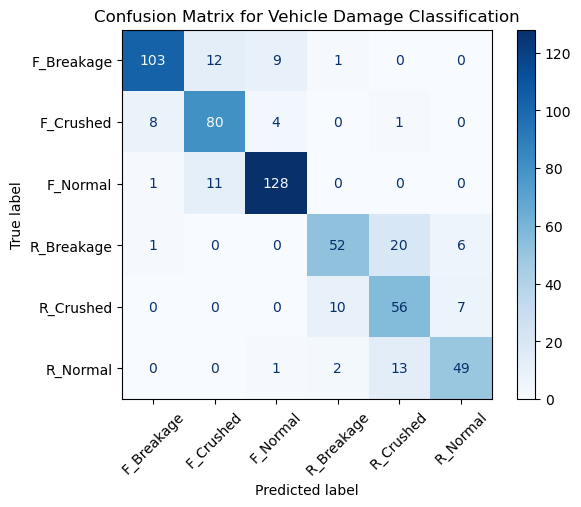

In [170]:
conf_matrix = confusion_matrix(labels, predictions, labels=np.arange(num_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix for Vehicle Damage Classification")
plt.show()

### Save the Model

In [172]:
torch.save(model.state_dict(), 'saved_model.pth')